# Tugas Klasifikasi Kelompok 7
**Data Mining and Data Warehouse**

- Ade Mulyana (2108799)
- Muhammad Alam Basalamah (2101677)
- Muhammad Rizki (2107922)
- Muhammad Yusuf Bahtiar (2107980)
- Rasyid Andriansyah (2101963)

In [1]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from datetime import datetime,date
from time import strptime
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
pd.set_option('display.max_columns', 500)

# Import warnings filter
from warnings import simplefilter

E:\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_ori =pd.read_csv('data_return\orders_train.txt', delimiter=";")

# Menampilkan atribut yang terdapat di dalam data frame beserta tipe datanya
print(data_ori.shape)

# Menampilkan data teratas di dalam data frame
print(list(data_ori))

# Mendeskripsikan data yang ada
print(data_ori.describe())

(481092, 14)
['orderItemID', 'orderDate', 'deliveryDate', 'itemID', 'size', 'color', 'manufacturerID', 'price', 'customerID', 'salutation', 'dateOfBirth', 'state', 'creationDate', 'returnShipment']
         orderItemID         itemID  manufacturerID          price  \
count  481092.000000  481092.000000   481092.000000  481092.000000   
mean   240546.500000    1399.764779       29.726109      70.440229   
std    138879.442189     931.075227       30.064934      45.502854   
min         1.000000       1.000000        1.000000       0.000000   
25%    120273.750000     332.000000        5.000000      34.900000   
50%    240546.500000    1569.000000       21.000000      59.900000   
75%    360819.250000    2342.000000       43.000000      89.900000   
max    481092.000000    3071.000000      166.000000     999.000000   

          customerID  returnShipment  
count  481092.000000   481092.000000  
mean    33369.968376        0.482425  
std     23972.075259        0.499692  
min         6.0

# PRAPROSES

In [3]:
# Mengecek value yang unik di dalam data frame
data_ori.nunique()

orderItemID       481092
orderDate            365
deliveryDate         328
itemID              3007
size                 122
color                 88
manufacturerID       165
price                379
customerID         59754
salutation             5
dateOfBirth        14309
state                 16
creationDate         775
returnShipment         2
dtype: int64

In [4]:
# Mengecek value yang bernilai NULL 
print(data_ori.isnull().sum())

orderItemID       0
orderDate         0
deliveryDate      0
itemID            0
size              0
color             0
manufacturerID    0
price             0
customerID        0
salutation        0
dateOfBirth       0
state             0
creationDate      0
returnShipment    0
dtype: int64


### Membuat beberapa kolom tambahan

In [5]:
# Mengubah tipe data
data_ori.head(6)
pd.Timestamp.max
data_ori["dateOfBirth"] = pd.to_datetime(data_ori["dateOfBirth"], errors = 'coerce')

In [6]:
# Data yang bervalue "?" diubah menjadi null karena tidak bisa di tebak
data_ori.deliveryDate=data_ori.deliveryDate.replace("?", np.nan)
data_ori.color=data_ori.color.replace("?", np.nan)
data_ori.dateOfBirth=data_ori.dateOfBirth.replace("?", np.nan)

In [7]:
# Mengecek nilai null pada setiap kolom 
print(data_ori.isnull().sum())

orderItemID           0
orderDate             0
deliveryDate      39419
itemID                0
size                  0
color               143
manufacturerID        0
price                 0
customerID            0
salutation            0
dateOfBirth       48892
state                 0
creationDate          0
returnShipment        0
dtype: int64


In [8]:
# Mengubah tipe data
data_ori["deliveryDate"] = pd.to_datetime(data_ori["deliveryDate"])
data_ori["orderDate"] = pd.to_datetime(data_ori["orderDate"])
data_ori["dateOfBirth"] = pd.to_datetime(data_ori["dateOfBirth"])
data_ori["creationDate"] = pd.to_datetime(data_ori["creationDate"])

# Membuat kolom deliverytime_days yang berisi hari di mana barang dikirimkan
data_ori["deliverytime_days"] = (data_ori["deliveryDate"] - data_ori["orderDate"])/np.timedelta64(1, 'D')

# Membuat kolom age_at_order_yrs yang berisi umur pembeli ketika mengorder barang
data_ori["age_at_order_yrs"] = (data_ori["orderDate"] - data_ori["dateOfBirth"])/np.timedelta64(1, 'Y')

# Membuat kolom product_age_days yang berisi umur barang ketika sampai di pembeli
data_ori["product_age_days"] = (data_ori["orderDate"] - data_ori["creationDate"])/np.timedelta64(1, 'D')

In [9]:
# Menghapus value yang hilang
data_ori.dropna(subset = ['deliveryDate'])
data_ori.dropna(subset = ['dateOfBirth'])

# Mengonversi value dari atribut orderDate menjadi hari ke dalam atribut day_of_week
data_ori['day_of_week'] = data_ori['orderDate'].dt.day_name()

data_ori.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,deliverytime_days,age_at_order_yrs,product_age_days,day_of_week
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0,2.0,47.234372,342.0,Sunday
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0,47.234372,342.0,Sunday
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0,47.234372,342.0,Sunday
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0,NaN,52.398064,89.0,Monday
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0,-7763.0,47.727195,411.0,Monday


In [10]:
# Menghapus kolom orderDate, deliveryDate, dateOfBirth, dan creationDate
data_ori = data_ori.drop("orderDate", 1)
data_ori = data_ori.drop("deliveryDate", 1)
data_ori = data_ori.drop("dateOfBirth", 1)
data_ori = data_ori.drop("creationDate", 1)

data_ori.head()

C:\Users\RASYID\AppData\Local\Temp\ipykernel_15916\1588327951.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_ori = data_ori.drop("orderDate", 1)
C:\Users\RASYID\AppData\Local\Temp\ipykernel_15916\1588327951.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_ori = data_ori.drop("deliveryDate", 1)
C:\Users\RASYID\AppData\Local\Temp\ipykernel_15916\1588327951.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_ori = data_ori.drop("dateOfBirth", 1)
C:\Users\RASYID\AppData\Local\Temp\ipykernel_15916\1588327951.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_ori = data_ori.drop("creationDate", 1)


,orderItemID,itemID,size,color,manufacturerID,price,customerID,salutation,state,returnShipment,deliverytime_days,age_at_order_yrs,product_age_days,day_of_week
0,1,186,m,denim,25,69.90,794,Mrs,Baden-Wuerttemberg,0,2.0,47.234372,342.0,Sunday
1,2,71,9+,ocher,21,69.95,794,Mrs,Baden-Wuerttemberg,1,2.0,47.234372,342.0,Sunday
2,3,71,9+,curry,21,69.95,794,Mrs,Baden-Wuerttemberg,1,2.0,47.234372,342.0,Sunday
3,4,22,m,green,14,39.90,808,Mrs,Saxony,0,NaN,52.398064,89.0,Monday
4,5,151,39,black,53,29.90,825,Mrs,Rhineland-Palatinate,0,-7763.0,47.727195,411.0,Monday


In [11]:
# Menghapus value yang bernilai negatif karena tidak masuk akal
data_ori = data_ori[data_ori['deliverytime_days'] >= 0]
data_ori = data_ori[data_ori["age_at_order_yrs"] >= 0]
data_ori = data_ori[data_ori["product_age_days"] >= 0]

data_ori.describe()

,orderItemID,itemID,manufacturerID,price,customerID,returnShipment,deliverytime_days,age_at_order_yrs,product_age_days
count,392430.000000,392430.000000,392430.000000,392430.000000,392430.000000,392430.000000,392430.000000,392430.000000,392430.000000
mean,241312.310432,1407.349869,29.853627,69.904607,32345.617534,0.528385,10.640007,48.569169,311.806597
std,138650.814789,928.214725,30.164870,45.259346,23555.480355,0.499194,17.916882,11.003492,257.657294
min,1.000000,1.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.082137,0.000000
25%,122736.500000,343.000000,5.000000,34.900000,12348.000000,0.000000,2.000000,42.514220,21.000000
50%,240399.500000,1575.000000,23.000000,59.900000,27327.500000,1.000000,3.000000,47.787429,310.000000
75%,361159.750000,2344.000000,43.000000,89.900000,49224.000000,1.000000,8.000000,53.413828,533.000000
max,481088.000000,3070.000000,166.000000,999.000000,86609.000000,1.000000,175.000000,112.363704,774.000000


### Mentransformasikan value dari atribut Size dan Color

In [12]:
# Mengecek value yang terdapat di dalam atribut Size
data_ori["size"].unique()

array(['m', '9+', 'xxl', '39', '43', '37', '38', 'l', 'xl', '42', '41',
       'unsized', 's', '10+', '40', '36', '152', '35', '34', '8+', '9',
       '46', '6', '25', '20', '5', '10', '42+', '44', '8', '3', '6+',
       '48', '7+', '22', '12', '45', '7', '24', '39+', '27', '32', '4+',
       '11', '26', '40+', '19', '21', '5+', '116', '2', '28', '11+',
       '36+', '164', '4', '33', '29', '50', '18', '41+', '1', '38+', '30',
       '31', '104', '128', '95', '37+', '3+', '140', '23', '13', 'S',
       '44+', 'xxxl', '54', '52', '47', '3434', '49', '84', '3332', '56',
       '13+', '76', '85', '176', '88', '45+', '14', 'L', '46+', '43+',
       '3632', '90', '3832', '3634', '4032', '3432', 'xs', '80', '2+',
       '100', '3132', '58', '4034', '3834', '12+', '2932', '110', '122',
       'XXL', 'M', 'XL', 'XXXL', '4232', 'XS', '92', '96', '3334', '105'],
      dtype=object)

In [13]:
# Mengonversi value dari atribut size yang kemungkinan barangnya adalah pakaian
data_ori["size"]= data_ori["size"].replace("S",33)
data_ori["size"]= data_ori["size"].replace("M",37)
data_ori["size"]= data_ori["size"].replace("L",41)
data_ori["size"]= data_ori["size"].replace("XL",45)
data_ori["size"]= data_ori["size"].replace("XXL",49)
data_ori["size"]= data_ori["size"].replace("XXXL",51)
data_ori["size"]= data_ori["size"].replace("xxxl",51)
data_ori["size"]= data_ori["size"].replace("s",33)
data_ori["size"]= data_ori["size"].replace("m",37)
data_ori["size"]= data_ori["size"].replace("l",41)
data_ori["size"]= data_ori["size"].replace("xl",45)
data_ori["size"]= data_ori["size"].replace("xxl",49)
data_ori["size"]= data_ori["size"].replace("S",33)
data_ori["size"]= data_ori["size"].replace("M",37)
data_ori["size"]= data_ori["size"].replace("L",41)
data_ori["size"]= data_ori["size"].replace("XL",45)
data_ori["size"]= data_ori["size"].replace("XXL",49)
data_ori["size"]= data_ori["size"].replace("XXXL",51)
data_ori["size"]= data_ori["size"].replace("xxxl",51)
data_ori["size"]= data_ori["size"].replace("xs",30)
data_ori["size"]= data_ori["size"].replace("XS",30)

In [14]:
# Mengonversi value dari atribut size yang kemungkinan barangnya adalah sepatu
data_ori["size"]= data_ori["size"].replace("10+",10)
data_ori["size"]= data_ori["size"].replace("11+",11)
data_ori["size"]= data_ori["size"].replace("12+",12)
data_ori["size"]= data_ori["size"].replace("2+",2)
data_ori["size"]= data_ori["size"].replace("3+",3)
data_ori["size"]= data_ori["size"].replace("36+",36)
data_ori["size"]= data_ori["size"].replace("37+",37)
data_ori["size"]= data_ori["size"].replace("38+",38)
data_ori["size"]= data_ori["size"].replace("39+",39)
data_ori["size"]= data_ori["size"].replace("40+",40)
data_ori["size"]= data_ori["size"].replace("41+",41)
data_ori["size"]= data_ori["size"].replace("42+",42)
data_ori["size"]= data_ori["size"].replace("43+",43)
data_ori["size"]= data_ori["size"].replace("44+",44)
data_ori["size"]= data_ori["size"].replace("45+",45)
data_ori["size"]= data_ori["size"].replace("46+",46)
data_ori["size"]= data_ori["size"].replace("5+",5)
data_ori["size"]= data_ori["size"].replace("6+",6)
data_ori["size"]= data_ori["size"].replace("7+",7)
data_ori["size"]= data_ori["size"].replace("8+",8)
data_ori["size"]= data_ori["size"].replace("9+",9)
data_ori["size"]= data_ori["size"].replace("4+",4)
data_ori["size"]= data_ori["size"].replace("13+",13)

In [15]:
# Menghapus data yang memiliki value "Unsized" dari atribut size
data_ori = data_ori[data_ori["size"] != "unsized"]

In [16]:
# Mengecek value yang terdapat di dalam atribut Color
data_ori["color"].unique()

array(['denim', 'ocher', 'curry', 'brown', 'red', 'green', 'mocca',
       'black', 'anthracite', 'olive', 'petrol', 'blue', 'grey', 'beige',
       'ecru', 'turquoise', 'magenta', 'purple', 'pink', 'khaki', 'navy',
       'habana', 'silver', 'white', 'stained', 'orange', 'azure',
       'apricot', 'nature', 'berry', 'ash', 'hibiscus', 'fuchsia', 'blau',
       'dark denim', 'mint', 'mango', 'ivory', 'yellow', 'bordeaux',
       'ancient', 'aquamarine', 'brwon', 'aubergine', 'almond', 'aqua',
       'dark garnet', 'avocado', 'creme', 'champagner', 'cortina mocca',
       'currant purple', 'cognac', 'aviator', 'gold', 'ebony',
       'cobalt blue', 'baltic blue', 'kanel', 'curled', 'antique pink',
       'dark grey', 'darkblue', 'copper coin', 'terracotta', 'basalt',
       'caramel', 'coral', 'jade', 'opal', 'amethyst', 'striped',
       'mahagoni', 'floral', 'dark navy', 'dark oliv', 'vanille',
       'ingwer', 'iron', 'graphite', 'leopard', 'oliv', 'bronze',
       'crimson', 'perlmu

In [17]:
# Membuat klasterisasi warna pada atribut Color
data_ori["color"]=data_ori["color"].replace("berry","red")
data_ori["color"]=data_ori["color"].replace("bordeaux","red")
data_ori["color"]=data_ori["color"].replace("dark garnet","red")
data_ori["color"]=data_ori["color"].replace("fuchsia","red")
data_ori["color"]=data_ori["color"].replace("crimson","red")
data_ori["color"]=data_ori["color"].replace("magenta","pink")
data_ori["color"]=data_ori["color"].replace("antique pink","pink")
data_ori["color"]=data_ori["color"].replace("pink","pink")
data_ori["color"]=data_ori["color"].replace("pallid","pink")
data_ori["color"]=data_ori["color"].replace("coral","pink")
data_ori["color"]=data_ori["color"].replace("hibiscus","red")
data_ori["color"]=data_ori["color"].replace("orange","orange")
data_ori["color"]=data_ori["color"].replace("apricot","orange")
data_ori["color"]=data_ori["color"].replace("ocher","yellow")
data_ori["color"]=data_ori["color"].replace("beige","yellow")
data_ori["color"]=data_ori["color"].replace("lemon","yellow")
data_ori["color"]=data_ori["color"].replace("vanille","yellow")
data_ori["color"]=data_ori["color"].replace("creme","yellow")
data_ori["color"]=data_ori["color"].replace("almond","yellow")
data_ori["color"]=data_ori["color"].replace("mango","yellow")
data_ori["color"]=data_ori["color"].replace("curry","yellow")
data_ori["color"]=data_ori["color"].replace("ancient","yellow")
data_ori["color"]=data_ori["color"].replace("ingwer","yellow")
data_ori["color"]=data_ori["color"].replace("gold","yellow")
data_ori["color"]=data_ori["color"].replace("oliv","green")
data_ori["color"]=data_ori["color"].replace("aquamarine","green")
data_ori["color"]=data_ori["color"].replace("nature olive","green")
data_ori["color"]=data_ori["color"].replace("nature","green")
data_ori["color"]=data_ori["color"].replace("avocado","green")
data_ori["color"]=data_ori["color"].replace("khaki","green")
data_ori["color"]=data_ori["color"].replace("mint","green")
data_ori["color"]=data_ori["color"].replace("jade","green")
data_ori["color"]=data_ori["color"].replace("gold","green")
data_ori["color"]=data_ori["color"].replace("olive","green")
data_ori["color"]=data_ori["color"].replace("dark oliv","green")
data_ori["color"]=data_ori["color"].replace("petrol","blue")
data_ori["color"]=data_ori["color"].replace("denim turquoise","blue")
data_ori["color"]=data_ori["color"].replace("turquoise","blue")
data_ori["color"]=data_ori["color"].replace("denim","blue")
data_ori["color"]=data_ori["color"].replace("dark denim","blue")
data_ori["color"]=data_ori["color"].replace("azure","blue")
data_ori["color"]=data_ori["color"].replace("navy","blue")
data_ori["color"]=data_ori["color"].replace("blau","blue")
data_ori["color"]=data_ori["color"].replace("aqua", "blue")
data_ori["color"]=data_ori["color"].replace("darkblue", "blue")
data_ori["color"]=data_ori["color"].replace("dark navy","blue")
data_ori["color"]=data_ori["color"].replace("baltic blue","blue")
data_ori["color"]=data_ori["color"].replace("cobalt blue","blue")
data_ori["color"]=data_ori["color"].replace("aubergine","purple")
data_ori["color"]=data_ori["color"].replace("amethyst","purple")
data_ori["color"]=data_ori["color"].replace("currant purple","purple")
data_ori["color"]=data_ori["color"].replace("ebony","black")
data_ori["color"]=data_ori["color"].replace("anthracite","grey")
data_ori["color"]=data_ori["color"].replace("ash","grey")
data_ori["color"]=data_ori["color"].replace("iron","grey")
data_ori["color"]=data_ori["color"].replace("dark grey","grey")
data_ori["color"]=data_ori["color"].replace("basalt","grey")
data_ori["color"]=data_ori["color"].replace("graphite","grey")
data_ori["color"]=data_ori["color"].replace("silver","grey")
data_ori["color"]=data_ori["color"].replace("stained","brown")
data_ori["color"]=data_ori["color"].replace("mocha","brown")
data_ori["color"]=data_ori["color"].replace("ecru","brown")
data_ori["color"]=data_ori["color"].replace("brwon","brown")
data_ori["color"]=data_ori["color"].replace("terracotta","brown")
data_ori["color"]=data_ori["color"].replace("bronze","brown")
data_ori["color"]=data_ori["color"].replace("cortina mocca","brown")
data_ori["color"]=data_ori["color"].replace("caramel","brown")
data_ori["color"]=data_ori["color"].replace("copper coin","brown")
data_ori["color"]=data_ori["color"].replace("cognac","brown")
data_ori["color"]=data_ori["color"].replace("mahagoni","brown")
data_ori["color"]=data_ori["color"].replace("habana","brown")
data_ori["color"]=data_ori["color"].replace("mocca","brown")
data_ori["color"]=data_ori["color"].replace("ivory","white")
data_ori["color"]=data_ori["color"].replace("champagner","white")
data_ori["color"]=data_ori["color"].replace("kanel","white")
data_ori["color"]=data_ori["color"].replace("perlmutt","white")
data_ori["color"]=data_ori["color"].replace("leopard","other")
data_ori["color"]=data_ori["color"].replace("opal","other")
data_ori["color"]=data_ori["color"].replace("curled","other")
data_ori["color"]=data_ori["color"].replace("aviator","other")
data_ori["color"]=data_ori["color"].replace("striped","other")
data_ori["color"]=data_ori["color"].replace("floral","other")

In [18]:
# Mengubah tipe data dari value atribut color menjadi string
data_ori['color'] = data_ori.color.astype(str)

data_ori['color'].describe()
data_ori['color'].value_counts()

black     68966
blue      68524
grey      48308
brown     44023
green     42400
red       38738
purple    17468
white     15627
yellow    14542
pink       8456
orange     2865
other       726
Name: color, dtype: int64

In [19]:
# Menampilkan 30 data teratas di dalam data frame
data_ori.head(30)

,orderItemID,itemID,size,color,manufacturerID,price,customerID,salutation,state,returnShipment,deliverytime_days,age_at_order_yrs,product_age_days,day_of_week
0,1,186,37,blue,25,69.90,794,Mrs,Baden-Wuerttemberg,0,2.0,47.234372,342.0,Sunday
1,2,71,9,yellow,21,69.95,794,Mrs,Baden-Wuerttemberg,1,2.0,47.234372,342.0,Sunday
2,3,71,9,yellow,21,69.95,794,Mrs,Baden-Wuerttemberg,1,2.0,47.234372,342.0,Sunday
7,8,32,49,brown,3,21.90,850,Mrs,North Rhine-Westphalia,1,1.0,63.984887,411.0,Monday
8,9,32,49,red,3,21.90,850,Mrs,North Rhine-Westphalia,1,1.0,63.984887,411.0,Monday
9,10,57,49,green,3,39.90,850,Mrs,North Rhine-Westphalia,1,1.0,63.984887,411.0,Monday
10,11,2,49,brown,2,39.90,850,Mrs,North Rhine-Westphalia,1,1.0,63.984887,411.0,Monday
11,12,259,39,black,1,119.90,850,Mrs,North Rhine-Westphalia,1,1.0,63.984887,411.0,Monday
12,13,603,39,black,55,169.90,850,Mrs,North Rhine-Westphalia,1,1.0,63.984887,411.0,Monday
13,14,259,39,yellow,1,119.90,850,Mrs,North Rhine-Westphalia,1,8.0,63.984887,411.0,Monday


In [20]:
# Mengubah tipe data dari value atribut day_of_week menjadi string
data_ori['day_of_week'] = data_ori.day_of_week.astype(str)

# Exploratory Data Analysis (EDA)

In [21]:
# import seaborn as sns

# # Melihat hubungan antara umur pembeli, harga barang, dan pengembalian
# sns.relplot(data=data_ori, kind="line", x="age_at_order_yrs", y="price", hue="returnShipment")

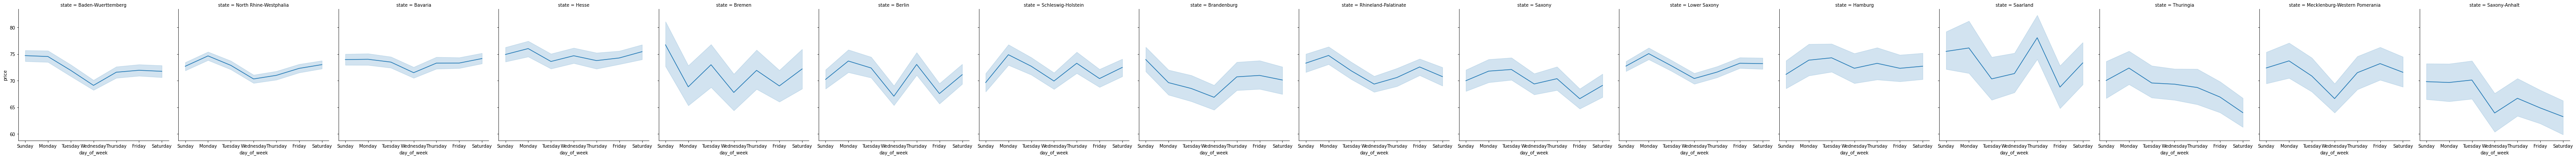

In [22]:
# Melihat hubungan antara harga barang dan hari di setiap kota
sns.relplot(col="state", y="price", kind="line",x='day_of_week', data=data_ori)
plt.show()

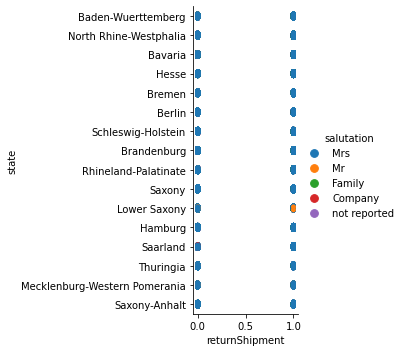

In [23]:
# Dari diagram diatas diketahui bahwa data barang yang direturn dan tidak direturn di setiap kota mayoritasmya adalah wanita, 
# namun terdapat 1 kota yang mereturn barang mayoritasnya adalah pria
sns.catplot(x="returnShipment", y="state", hue="salutation", data=data_ori)

<AxesSubplot:xlabel='state', ylabel='count'>

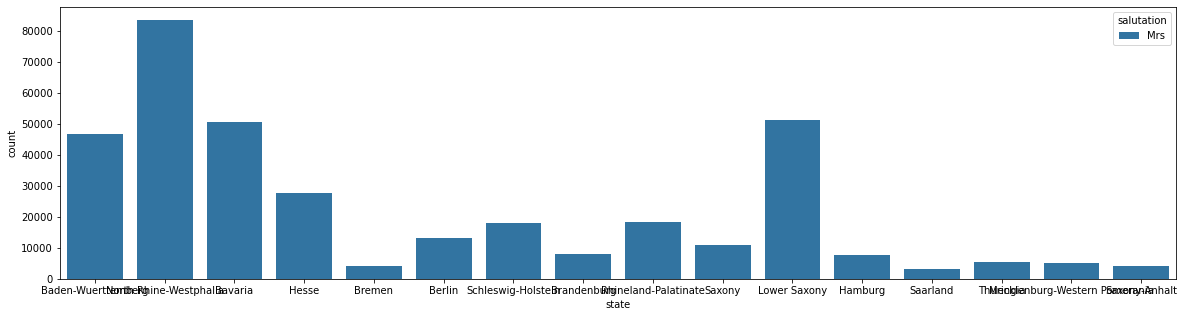

In [24]:
# Melihat Data dari banyak pembelian oleh wanita pada setiap kota
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(ax=ax, x="state", hue="salutation", data=data_ori[data_ori.salutation=="Mrs"])

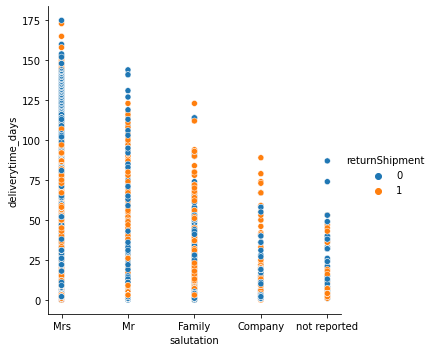

In [25]:
# Dengan menggunakan catplot, dapat mengetahui hubungan antara salutation, delivery time, return shipment
# sehingga bisa diketahui bahwa ada 1 salutation yang memiliki index return barang lebih tinggi dari yang lain
sns.relplot(x="salutation", y="deliverytime_days", hue="returnShipment", data=data_ori)

<AxesSubplot:xlabel='returnShipment', ylabel='count'>

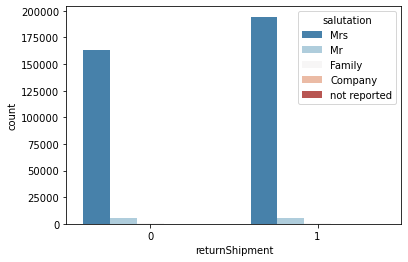

In [26]:
# Melihat jumlah returnShipment berdasarkan salutation
sns.countplot(x='returnShipment',hue='salutation',data=data_ori,palette='RdBu_r')

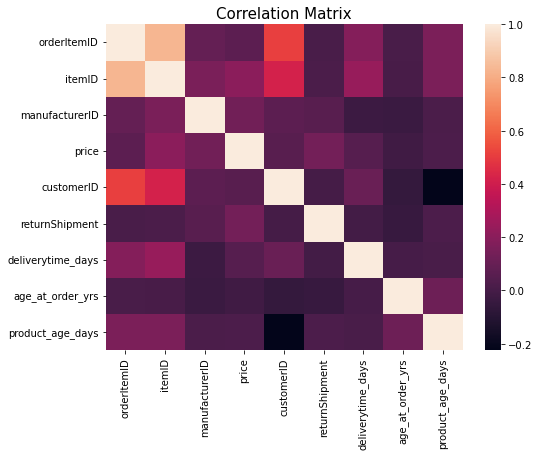

In [28]:
# Melihat korelasi dari matrix
plt.figure(figsize=(8,6))
corr=data_ori.corr()
plt.title("Correlation Matrix",fontsize="15")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

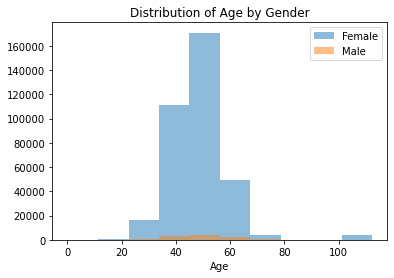

In [29]:
# Melihat distribusi gender berdasarkan usia
plt.hist('age_at_order_yrs', data=data_ori[data_ori['salutation'] == 'Mrs'], alpha=0.5, label='Female');
plt.hist('age_at_order_yrs', data=data_ori[data_ori['salutation'] == 'Mr'], alpha=0.5, label='Male');
plt.title('Distribution of Age by Gender');
plt.xlabel('Age');
plt.legend();

<AxesSubplot:xlabel='state'>

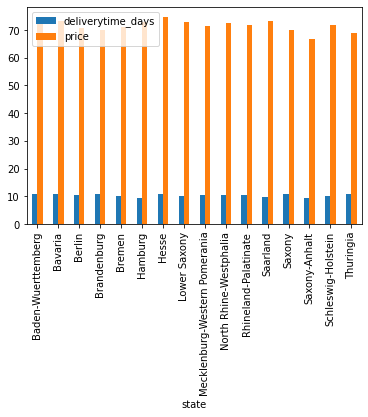

In [30]:
# Melihat korelasi antara rata-rata waktu pengiriman dengan harga barang di setiap kota
df_color = data_ori.groupby(['state'])[['deliverytime_days', 'price']].mean()
df_color.plot(kind='bar')

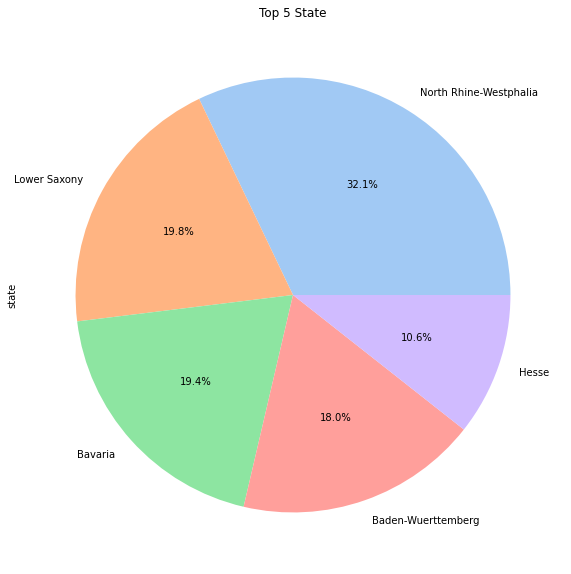

In [31]:
# Melihat 5 kota teratas yang sering melakukan transaksi
plt.figure(figsize=(15,10))
plt.title('Top 5 State')
colors = sns.color_palette("pastel", 9)
data_ori["state"].value_counts().nlargest(n=5).plot.pie(autopct='%1.1f%%',figsize=(15,10), colors=colors)
plt.show()

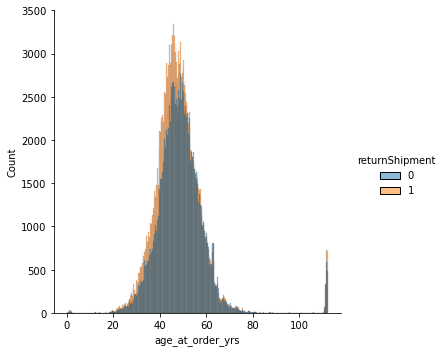

In [33]:
# Dari diagram dibawah diketahui bahwa pembeli dengan umur di range 40-60 tahun lebih sering melakukan penukaran barang
sns.displot(data_ori, x="age_at_order_yrs", hue="returnShipment", kind="hist")

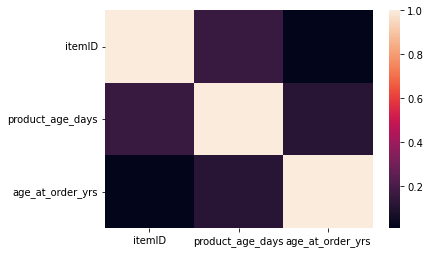

In [34]:
# Dengan menggunakan heatmap dapat diketahui bahwa atribut durasi_pengriman tidak memiliki korelasi sama sekali dengan atribut umur produk dan umur pembeli
corr = data_ori[["itemID","product_age_days","age_at_order_yrs"]].corr()
ax = sns.heatmap(corr)

<AxesSubplot:title={'center':'Rata-rata jumlah pengeluaran Tiap kota'}, xlabel='state'>

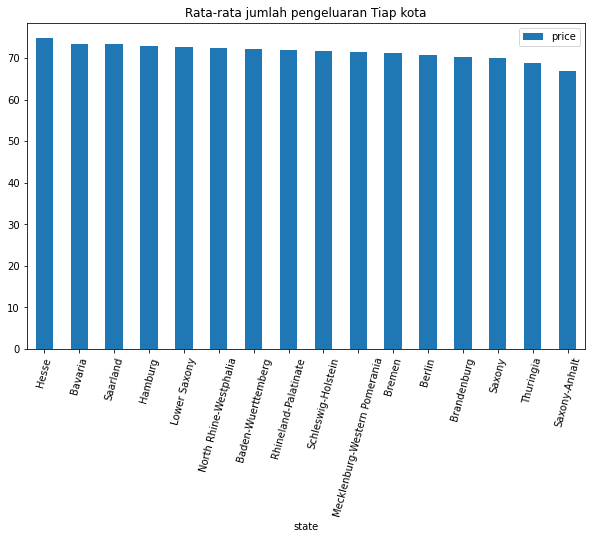

In [35]:
# Melihat rata-rata pengeluaran dari berbagai kota yang berbeda
data_ori[['state','price']].groupby('state').mean().sort_values(by='price', ascending=False).plot.bar(figsize=(10,6), rot=75, title='Rata-rata jumlah pengeluaran Tiap kota')

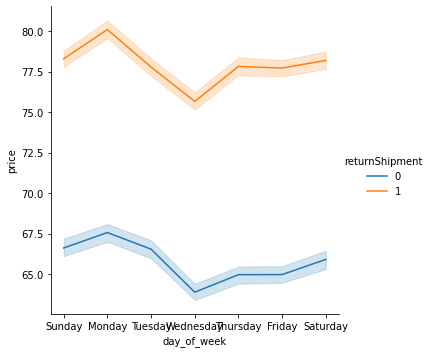

In [36]:
# Melihat data return barang berdasarkan price dan hari
sns.relplot(hue="returnShipment", y="price", kind="line",x='day_of_week', data=data_ori)

### One Hot Encoding Untuk merepresentasikan biner pada variabel string

In [37]:
# Proses One Hot Encoding untuk atribut color, salutation, state, dan day_of_week
data_ori = pd.get_dummies(data=data_ori, columns=['color', 'salutation','state', 'day_of_week'])

data_ori.head()

,orderItemID,itemID,size,manufacturerID,price,customerID,returnShipment,deliverytime_days,age_at_order_yrs,product_age_days,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_other,color_pink,color_purple,color_red,color_white,color_yellow,salutation_Company,salutation_Family,salutation_Mr,salutation_Mrs,salutation_not reported,state_Baden-Wuerttemberg,state_Bavaria,state_Berlin,state_Brandenburg,state_Bremen,state_Hamburg,state_Hesse,state_Lower Saxony,state_Mecklenburg-Western Pomerania,state_North Rhine-Westphalia,state_Rhineland-Palatinate,state_Saarland,state_Saxony,state_Saxony-Anhalt,state_Schleswig-Holstein,state_Thuringia,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,1,186,37,25,69.90,794,0,2.0,47.234372,342.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2,71,9,21,69.95,794,1,2.0,47.234372,342.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,3,71,9,21,69.95,794,1,2.0,47.234372,342.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,8,32,49,3,21.90,850,1,1.0,63.984887,411.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
8,9,32,49,3,21.90,850,1,1.0,63.984887,411.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [38]:
#menyiapkan data train dan test, cara pertama adalah dengan teknik hold out. 
from sklearn.model_selection import train_test_split
X = data_ori.drop(['returnShipment'],axis=1) #training features
Y = data_ori['returnShipment'] # target variable
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=123)

# Menyimpan nama kolom untuk keperluan prediksi nanti
import pickle
with open('x_train_columns.pickle', 'wb') as fp:
    pickle.dump(X_train.columns, fp)

In [39]:
# Proses Normalisasi
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

## Modeling

In [40]:
## Pembentukan Model Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
clf = GaussianNB()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print(classification_report(Y_test, Y_pred))

Akurasi 0.5432691659134752
              precision    recall  f1-score   support

           0       0.51      0.21      0.30     34103
           1       0.55      0.82      0.66     40026

    accuracy                           0.54     74129
   macro avg       0.53      0.52      0.48     74129
weighted avg       0.53      0.54      0.50     74129



In [41]:
## Pembentukan model decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print(classification_report(Y_test, Y_pred))


Akurasi 0.5739858894629633
              precision    recall  f1-score   support

           0       0.54      0.53      0.53     34103
           1       0.60      0.61      0.61     40026

    accuracy                           0.57     74129
   macro avg       0.57      0.57      0.57     74129
weighted avg       0.57      0.57      0.57     74129



In [42]:
##Pembentukan model random forest
clf =RandomForestClassifier(random_state=1,n_estimators=200,class_weight='balanced',
                    min_samples_leaf=5,
                       min_samples_split=10)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print(classification_report(Y_test, Y_pred))


Akurasi 0.6253827786696164
              precision    recall  f1-score   support

           0       0.61      0.51      0.56     34103
           1       0.64      0.72      0.67     40026

    accuracy                           0.63     74129
   macro avg       0.62      0.62      0.62     74129
weighted avg       0.62      0.63      0.62     74129



In [43]:
## melakukan export modelling
import joblib
import pandas as pd
joblib.dump(clf, 'rforest_order.joblib')


['rforest_order.joblib']

In [44]:
#Membuka data order class
data_pred = pd.read_csv('order.csv')

In [45]:
data_pred.head()

,Unnamed: 0,orderItemID,itemID,size,color,manufacturerID,price,customerID,salutation,state,deliverytime_days,age_at_order_yrs,product_age_days,day_of_week
0,0,1,2347,43,pink,1,89.9,12489,Mrs,Hesse,2.0,49.933948,343.0,Monday
1,1,2,2741,43,grey,1,99.9,12489,Mrs,Hesse,2.0,49.933948,343.0,Monday
2,2,3,2514,9,brown,19,79.9,12489,Mrs,Hesse,2.0,49.933948,343.0,Monday
3,3,4,2347,42,brown,1,89.9,12489,Mrs,Hesse,35.0,49.933948,343.0,Monday
4,5,6,2318,41,blue,1,89.9,3649,Mrs,Hesse,1.0,57.016913,0.0,Monday


In [46]:
#Menghapus salah satu kolom
data_pred.drop(["Unnamed: 0"], axis=1, inplace=True)

In [47]:
#Melakukan hot encoding
data_pred = pd.get_dummies(data=data_pred, columns=['color','salutation','state', 'day_of_week'])

In [48]:
data_pred.head(10)

,orderItemID,itemID,size,manufacturerID,price,customerID,deliverytime_days,age_at_order_yrs,product_age_days,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_other,color_pink,color_purple,color_red,color_white,color_yellow,salutation_Company,salutation_Family,salutation_Mr,salutation_Mrs,salutation_not reported,state_Baden-Wuerttemberg,state_Bavaria,state_Berlin,state_Brandenburg,state_Bremen,state_Hamburg,state_Hesse,state_Lower Saxony,state_Mecklenburg-Western Pomerania,state_North Rhine-Westphalia,state_Rhineland-Palatinate,state_Saarland,state_Saxony,state_Saxony-Anhalt,state_Schleswig-Holstein,state_Thuringia,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,1,2347,43,1,89.90,12489,2.0,49.933948,343.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,2741,43,1,99.90,12489,2.0,49.933948,343.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,2514,9,19,79.90,12489,2.0,49.933948,343.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4,2347,42,1,89.90,12489,35.0,49.933948,343.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,6,2318,41,1,89.90,3649,1.0,57.016913,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,7,2590,7,57,99.90,3649,21.0,57.016913,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,8,2656,41,1,79.90,3649,73.0,57.016913,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,9,335,34,51,29.90,22284,1.0,46.144685,775.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
8,11,2452,37,5,59.90,22026,8.0,54.892298,775.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,19,2879,27,69,35.95,77874,25.0,26.352355,31.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [49]:
#import data train
import pickle
with open ('C:\\Users\\RASYID\\Coding\\x_train_columns.pickle', 'rb') as fp:
    X_train_column = list(pickle.load(fp))

In [50]:
data_pred = data_pred[X_train_column]

In [51]:
#Memanggil Modeling
import joblib
clf = joblib.load("C:\\Users\\RASYID\\\Coding\\rforest_order.joblib")
clf.predict(data_pred)


E:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [52]:
data_pred.head()

,orderItemID,itemID,size,manufacturerID,price,customerID,deliverytime_days,age_at_order_yrs,product_age_days,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_other,color_pink,color_purple,color_red,color_white,color_yellow,salutation_Company,salutation_Family,salutation_Mr,salutation_Mrs,salutation_not reported,state_Baden-Wuerttemberg,state_Bavaria,state_Berlin,state_Brandenburg,state_Bremen,state_Hamburg,state_Hesse,state_Lower Saxony,state_Mecklenburg-Western Pomerania,state_North Rhine-Westphalia,state_Rhineland-Palatinate,state_Saarland,state_Saxony,state_Saxony-Anhalt,state_Schleswig-Holstein,state_Thuringia,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,1,2347,43,1,89.9,12489,2.0,49.933948,343.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,2741,43,1,99.9,12489,2.0,49.933948,343.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,2514,9,19,79.9,12489,2.0,49.933948,343.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4,2347,42,1,89.9,12489,35.0,49.933948,343.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,6,2318,41,1,89.9,3649,1.0,57.016913,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Melakukan Prediksi

In [53]:
data_final = pd.DataFrame()
data_final['orderItemID'] = data_pred['orderItemID']
data_final['prediction'] = clf.predict(data_pred)

E:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [54]:
data_final.head()

,orderItemID,prediction
0,1,1
1,2,1
2,3,1
3,4,1
4,6,1


In [55]:
data_final.to_csv('order_class_final.txt', sep=';', index=False)